## Looking for early signs of Climate Change in the Antarctic

#### 0. Importing the necessary libraries

In [18]:
# Numerical and data analysis libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Modeling libraries
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


### 1. Sea Ice Extent

In [3]:
df = pd.read_csv('Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication.csv')
df.head()

,Ship,date,Latitude,Longitude,Temp (air),Temp (sea),mBar,Weather,Wind,Strength (Wind),...,Humpback Whale,Sperm Whales,Sei Whale,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,Solglimt,10/23/1932,-54.100,5.100,NaN,NaN,979.0,l,N,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Solglimt,10/24/1932,-53.583,4.800,NaN,NaN,986.0,d,NW,4.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Solglimt,10/25/1932,-53.300,4.000,NaN,NaN,993.0,d,NW,4.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Solglimt,10/26/1932,-53.617,3.600,NaN,NaN,994.0,c,WSW,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Solglimt,10/27/1932,-53.400,3.333,NaN,NaN,1018.0,d,WNW,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Extracting Ice Observations from the Dataset

This code processes the main dataset (`df`) to extract sea ice observations marked with "G" or "H" (likely indicating types of ice). It creates a new DataFrame (`ice_df`) with structured columns for year, month, date, ice type, latitude, and longitude. This transformation prepares the data for visualization and analysis of ice distribution over time.


In [4]:
import warnings
warnings.filterwarnings("ignore")

# Convert 'date' to datetime
df["date_parsed"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

# Extract date components
df["Year"] = df["date_parsed"].dt.year
df["Month"] = df["date_parsed"].dt.month
df["Day"] = df["date_parsed"].dt.day

# Initialize structured DataFrame
ice_df = pd.DataFrame(columns=["Year", "Month", "Date", "Letter", "Lat", "Lon"])

# Loop to extract G and H letters into new rows
for i, row in df.iterrows():
    ice_val = row["Ice"]
    if isinstance(ice_val, str):
        for letter in ["G", "H"]:
            if letter in ice_val:
                ice_df.loc[len(ice_df)] = [
                    row["Year"], row["Month"], row["Day"],
                    letter, row["Latitude"], row["Longitude"]
                ]

# Display cleaned ice data
ice_df

,Year,Month,Date,Letter,Lat,Lon
0,1935,11,26,G,-56.500,23.233
1,1935,11,27,G,-56.733,23.650
2,1935,11,28,G,-56.483,24.517
3,1935,11,29,G,-56.850,24.533
4,1935,11,30,G,-57.067,24.250
...,...,...,...,...,...,...
509,1959,3,9,G,-68.867,16.750
510,1959,12,5,H,-55.883,-9.700
511,1959,12,6,H,-55.050,-5.967
512,1959,12,9,H,-56.267,11.750


#### Visualization of Pack Ice Observations (Type H)

This plot shows the global distribution of all sea ice observations labeled with the letter "H" (likely indicating a specific ice condition or type, e.g., "Pack Ice") from the dataset. Each observation is color-coded by the year it was recorded, using an azimuthal equal area projection to emphasize polar regions like Antarctica.


In [7]:
# Filter the ice_df DataFrame to include only "H" observations (e.g., Pack Ice)
h_data = ice_df[ice_df["Letter"] == "H"]

# Create a geographic scatter plot of these observations
h_plot = px.scatter_geo(
    h_data,
    lat="Lat",                # Latitude column
    lon="Lon",                # Longitude column
    color="Year",             # Color points by year of observation
    projection="azimuthal equal area",  # Map projection suited for polar regions
    title="All Observations of Pack Ice by Year"
)

# Display the interactive plot
h_plot.show()

#### Monthly Geographic Distribution of Pack Ice Observations (Type H)

This visualization compares the spatial distribution of "H" type sea ice observations (likely pack ice) over six months: November through April. Each subplot shows a different month with color indicating the observation year. The plots are displayed using geographic scatter plots arranged in a grid layout, making it easier to compare seasonal patterns of ice distribution.


In [9]:
# Map the months of interest
months = [11, 12, 1, 2, 3, 4]
month_names = {11: "November", 
               12: "December", 
               1: "January", 
               2: "February", 
               3: "March", 
               4: "April"}

# Filter data for each month and store in a map
h_monthly = {
    month: ice_df[(ice_df['Letter'] == "H") & (ice_df["Month"]== month)]
    for month in months
}

# Create subplots: 3 rows x 2 columns
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[month_names[m] for m in months],
    specs=[[{"type": "scattergeo"}, {"type": "scattergeo"}],
           [{"type": "scattergeo"}, {"type": "scattergeo"}],
           [{"type": "scattergeo"}, {"type": "scattergeo"}]]
)

# Generate and insert scatter plots for each non-empty month's data
# April is not plotted because it has no data
row, col = 1, 1
for month in months:
    data = h_monthly[month]
    if not data.empty:
        plot = px.scatter_geo(data, lat = "Lat", lon = "Lon", color = "Year")
        for trace in plot.data:
            fig.add_trace(trace, row = row, col = col)
        
        if col == 1:
            col = 2
        else:
            col = 1
            row += 1
    
# Final layout adjustments

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    title="Observations of Pack Ice by Month and Year"
)

fig.show()
    

#### Average Latitude of Pack Ice Observations by Time Span

This analysis groups "H"-type pack ice observations by month (December, January, February) and five-year periods (1935–1964). For each month and time span, it calculates the average latitude of observations and the total number of records. The resulting trend lines reveal how the average position of observed pack ice has changed over time, potentially indicating shifts in sea ice extent or observation patterns.


In [10]:
time_bins = [(1935, 1939), (1940, 1944), (1945, 1949), (1950, 1954), (1955, 1959), (1960, 1964)]
time_labels = ["1935-1939", "1940-1944", "1945-1949", "1950-1954", "1955-1959", "1960-1964"]

def compute_avg_lat(df : pd.DataFrame) -> pd.DataFrame:
    '''
    Compute the average latitude of pack ice observations by month and time span

    Args:
        df (pd.DataFrame): DataFrame containing ice observation data

    Returns:
        pd.DataFrame: DataFrame with average latitude and count of observations
    '''
    result = pd.DataFrame(columns = ['Time Span', 'Avg Lat', 'Total'])
    lat_map = {label: [] for label in time_labels}

    for _, row in df.iterrows():
        for (start, end), label in zip(time_bins, time_labels):
            if start <= row['Year'] <= end:
                lat_map[label].append(row['Lat'])
                break
            
    for label in time_labels:
        if lat_map[label]: # avoid division by zero
            avg = np.mean(lat_map[label])
            count = len(lat_map[label])
            result.loc[len(result)] = [label, avg, count]
    return result


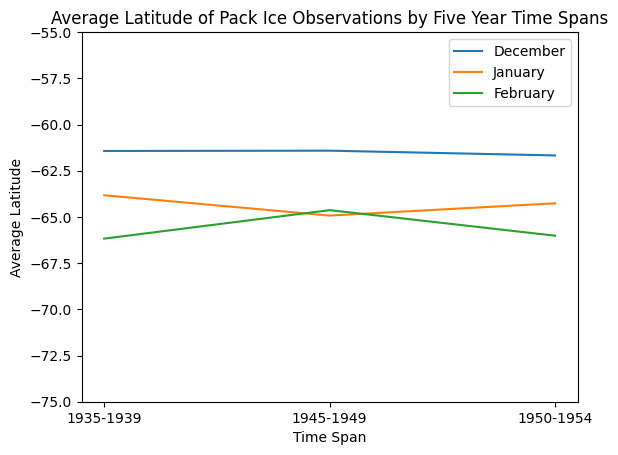

In [12]:
# Apply function to each month
dec_avg = compute_avg_lat(h_monthly[12])
jan_avg = compute_avg_lat(h_monthly[1])
feb_avg = compute_avg_lat(h_monthly[2])

# Plot results
sns.lineplot(data=dec_avg.iloc[:3], x="Time Span", y="Avg Lat", label="December")
sns.lineplot(data=jan_avg.iloc[:3], x="Time Span", y="Avg Lat", label="January")
sns.lineplot(data=feb_avg.iloc[:3], x="Time Span", y="Avg Lat", label="February").set(ylabel="Average Latitude")
plt.ylim(-75, -55)
plt.title("Average Latitude of Pack Ice Observations by Five Year Time Spans")
plt.show()


### 2. Sea Surface Temperature

#### a. Data preprocessing

In [13]:
dlta = df[['date', 'Latitude', 'Temp (sea)']].copy()
dlta.dropna(inplace=True)
dlta = dlta[dlta['Latitude']<-55]
dlta.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4330 entries, 148 to 6250
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        4330 non-null   object 
 1   Latitude    4330 non-null   float64
 2   Temp (sea)  4330 non-null   float64
dtypes: float64(2), object(1)
memory usage: 135.3+ KB


In [17]:
# Convert date to month and year
dlta['month'] = pd.to_datetime(dlta['date']).dt.month
dlta['year'] = pd.to_datetime(dlta['date']).dt.year

# Cyclic transformation of month
dlta['month_sin'] = np.sin(2 * np.pi * dlta['month'] / 12)
dlta['month_cos'] = np.cos(2 * np.pi * dlta['month'] / 12)

# Normalize year
dlta['year'] = (dlta['year'] - dlta['year'].mean()) / dlta['year'].std()


In [19]:
# Define feature and target
x = dlta[['month_sin', 'month_cos', 'year', 'Latitude']]
y = dlta['Temp (sea)']

# Split for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
residuals_rf = y_test - y_pred_rf

# Print evaluation metrics
print("Random Forest R^2:", r2_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest R^2: 0.42941859525816795
Random Forest RMSE: 0.9089113886767688


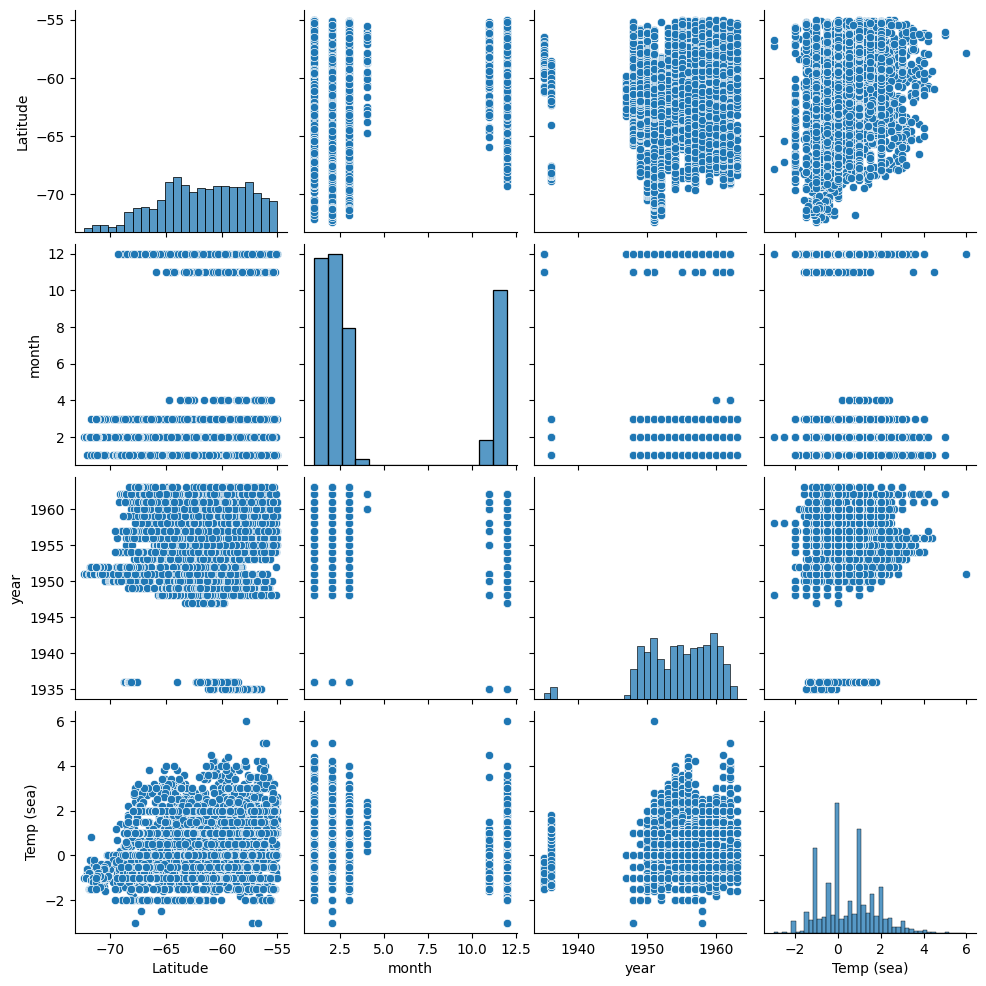

In [21]:
# Visualize the relationship between features and target
dlta['year'] = pd.to_datetime(dlta['date']).dt.year
sns.pairplot(dlta[['Latitude', 'month', 'year','Temp (sea)']])

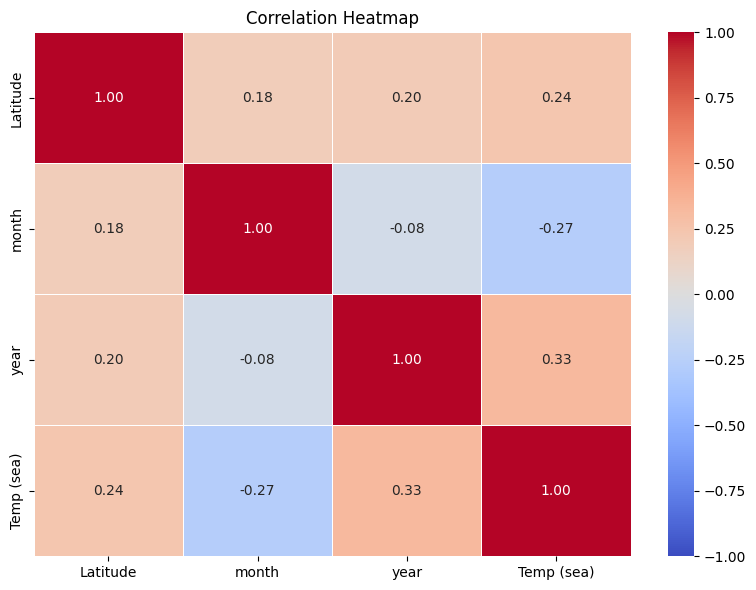

In [24]:
corr_matrix = dlta[['Latitude', 'month', 'year', 'Temp (sea)']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',     # red for positive, blue for negative
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1       # force color scale: blue = -1, red = +1
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Feature importances (normalized): [np.float64(0.15550179315460055), np.float64(0.3316350222402596), np.float64(0.5128631846051399)]


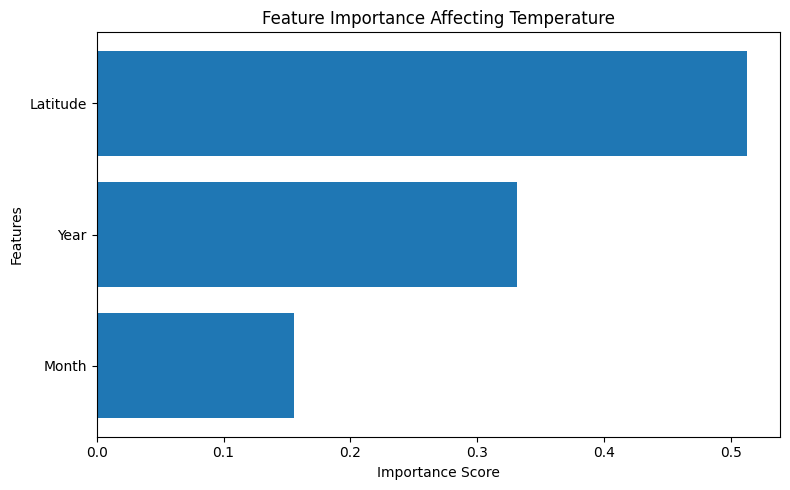

In [23]:
# Feature importance
feature = rf_model.feature_importances_
feature = [1-(feature[2]+feature[3]), feature[2], feature[3]]
print("Feature importances (normalized):", feature)

# Corresponding feature names
feature_names = ['Month', 'Year', 'Latitude']

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, feature)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance Affecting Temperature")
plt.tight_layout()
plt.show()

### 3. Air temperature

This analysis compares monthly air temperature using two datasets.

In [28]:
# Load datasets
df = pd.read_csv('Bjorge_et_al_catchlogbook_whaling_weather_data_1932-63_data_publication.csv')
new_data_path = 'Divine_et_al_data_publication_Antarctic_logbooks_v2_Nov2023_final.xlsx'
new_data_df = pd.read_excel(new_data_path)

#### Data filtering and preprocessing

We clean and filter out rows with missing temperature values. Then we categorize latitude into zones and extract seasonally relevant months.


In [29]:
# Filter out rows with missing air temperature values
temp_df = df[df['Temp (air)'].notna()].copy()
new_data_df_filtered = new_data_df.dropna(subset=['Temp (air), C'])

# Define latitude bands for whaling expedition
lat_bins = [-70, -60, -50, -40]
lat_labels = ['60-70°S', '50-60°S', '40-50°S']
temp_df['lat_zone'] = pd.cut(temp_df['Latitude'], bins=lat_bins, labels=lat_labels)

# Tag Antarctic dataset as single zone
new_data_df_filtered['lat_zone'] = 'Antarctic'


KeyError: ['Temp (air), C']